In [1]:
%pip install pandas
%pip install numpy
import pandas as pd
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data Processing

### Loading in DataSet

In [6]:
data = pd.read_csv('../data/realtor-data.csv')  # load in data
California = data[data['state'] == 'California']  # filtering just the data from California 
California = California.dropna() # Delets all rows that have an NA value in them so we dont have to deal with them in ML model


### Data Analysis

In [8]:
# Drop non-numeric columns
California_numeric = California.select_dtypes(include=[np.number])   # here we are just going to look at the numeric values to be able visualize the numerical values and their corelation 

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

def calculate_correlation(dataframe, target_column):   #this function should give us a visual representation of the correlation of the data points, we are more interested in teh price collumn
    # Select numerical columns and calculate correlation
    numerical_data = dataframe.select_dtypes(include=['float64', 'int64'])
    correlation_matrix = numerical_data.corr()
    
    # Visualize the correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
    plt.show()
    
    # Focus on correlations of features with the target
    target_correlation = correlation_matrix[target_column].sort_values(ascending=False)
    print("Correlations with the target variable:\n", target_correlation)
    
    # Scatter plots for the most correlated variables
    for col in numerical_data.columns:
        if col != target_column:
            dataframe.plot(kind='scatter', x=col, y=target_column, alpha=0.5)
            plt.title(f'Scatter plot of {target_column} vs {col}')
            plt.show()
    
    # For categorical data: One-Hot Encoding
    # Assuming 'status' is the only categorical column for simplicity
    if 'status' in dataframe.columns:
        one_hot_encoder = OneHotEncoder()
        status_encoded = one_hot_encoder.fit_transform(dataframe[['status']]).toarray()
        for i, category in enumerate(one_hot_encoder.categories_[0]):
            dataframe[category] = status_encoded[:, i]
    
    # Feature Importance with Random Forest
    if 'status' in dataframe.columns:
        X = dataframe.drop([target_column, 'status'], axis=1)
        X = pd.concat([X, pd.DataFrame(status_encoded, columns=one_hot_encoder.categories_[0])], axis=1)
    else:
        X = dataframe.drop(target_column, axis=1)
    y = dataframe[target_column]
    
    # Fitting the model
    model = RandomForestRegressor()
    model.fit(X, y)
    
    # Getting the feature importance
    importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
    importance = importance.sort_values(by='Importance', ascending=False)
    print("Feature Importances:\n", importance)
    
    return target_correlation, importance


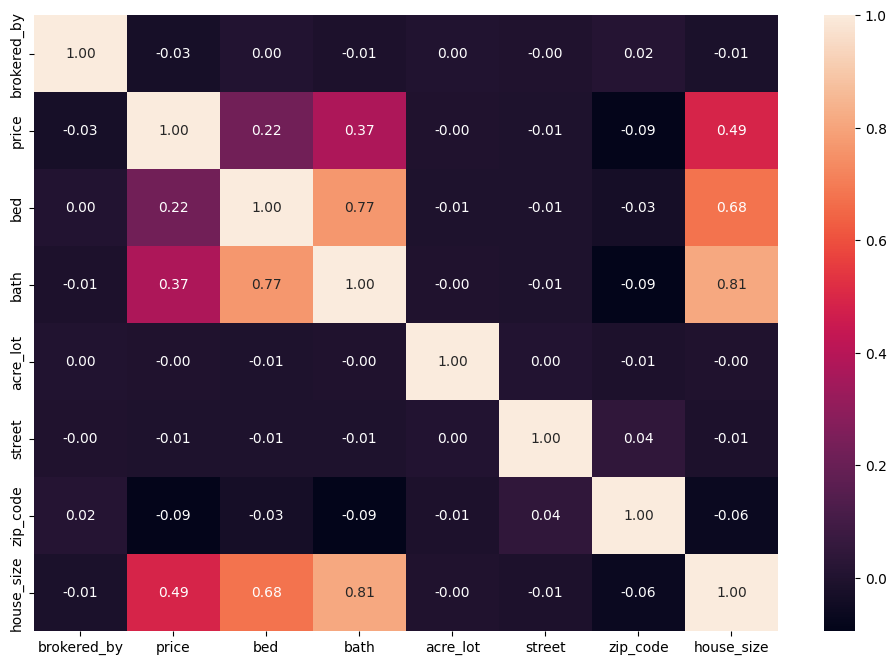

Correlations with the target variable:
 price          1.000000
house_size     0.489352
bath           0.374790
bed            0.222524
acre_lot      -0.001889
street        -0.008243
brokered_by   -0.026809
zip_code      -0.089278
Name: price, dtype: float64


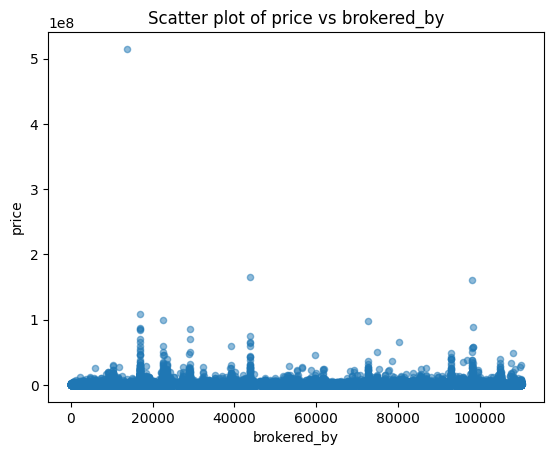

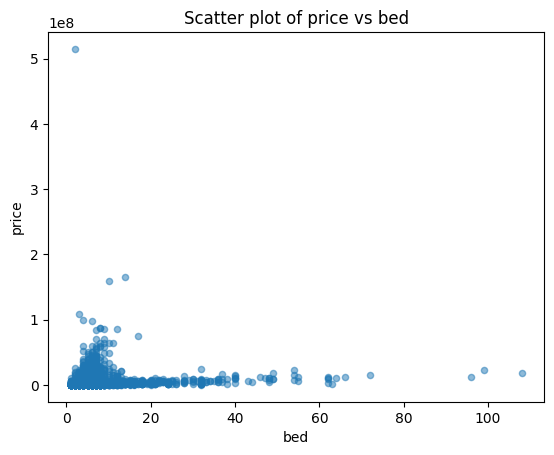

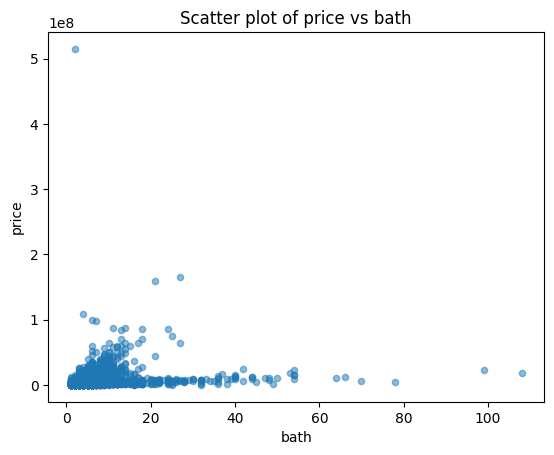

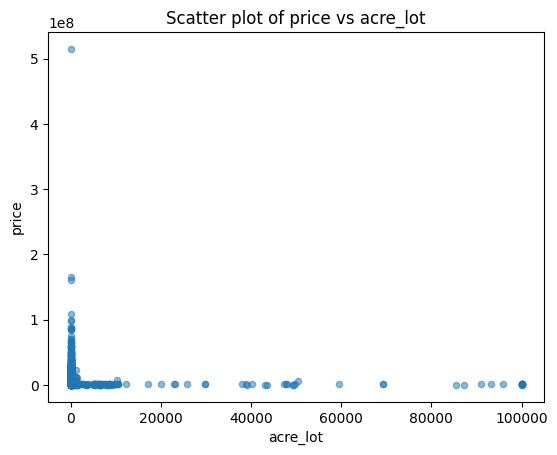

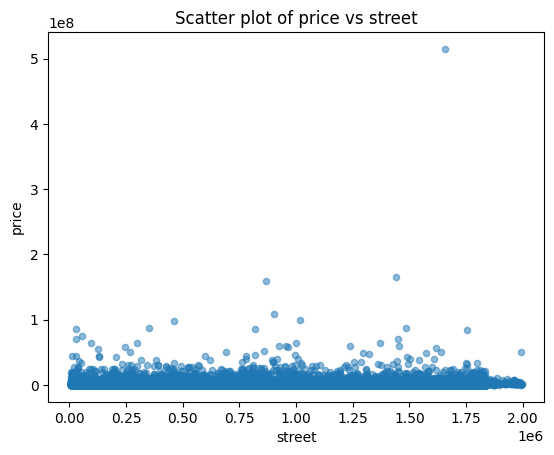

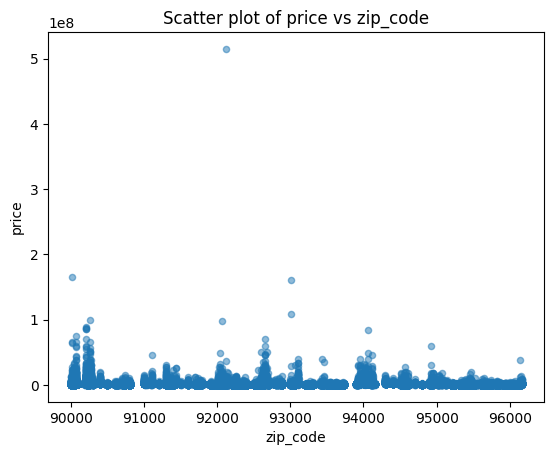

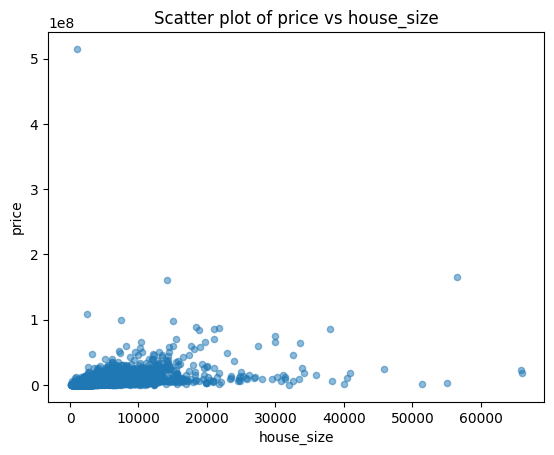

Feature Importances:
        Feature  Importance
6   house_size    0.377085
0  brokered_by    0.201233
5     zip_code    0.133731
3     acre_lot    0.111751
2         bath    0.063228
4       street    0.059606
1          bed    0.053367


In [10]:
# Now call the function using the numeric dataframe and 'price' as the target column
correlation_results, feature_importance_results = calculate_correlation(California_numeric, 'price')


This data is not great, we have no cleaned the data for outliers and we are looking at too large of a data area where prices can be massively spread out

### Outlier Handeling

In [13]:
def remove_outliers(df):
    # Iterate over each column in the DataFrame
    for column in df.select_dtypes(include=['number']).columns:
        # Calculate Q1 and Q3
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        # Calculate the IQR (Interquartile Range)
        IQR = Q3 - Q1
        # Define the bounds for the outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filter out outliers and keep only valid data
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplots(df):
    # Select only numerical columns for plotting
    num_cols = df.select_dtypes(include=['number']).columns
    num_of_cols = len(num_cols)
    # Set up the matplotlib figure size based on the number of columns
    plt.figure(figsize=(10, 5 * num_of_cols))
    
    # Iterate through the numerical columns and create a box plot for each one
    for index, column in enumerate(num_cols):
        plt.subplot(num_of_cols, 1, index + 1)
        sns.boxplot(x=df[column])
        plt.title(f'Box plot of {column}')
        plt.xlabel(column)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

#### Here we will look at the unadjusted box plots that show all the outliers that we have

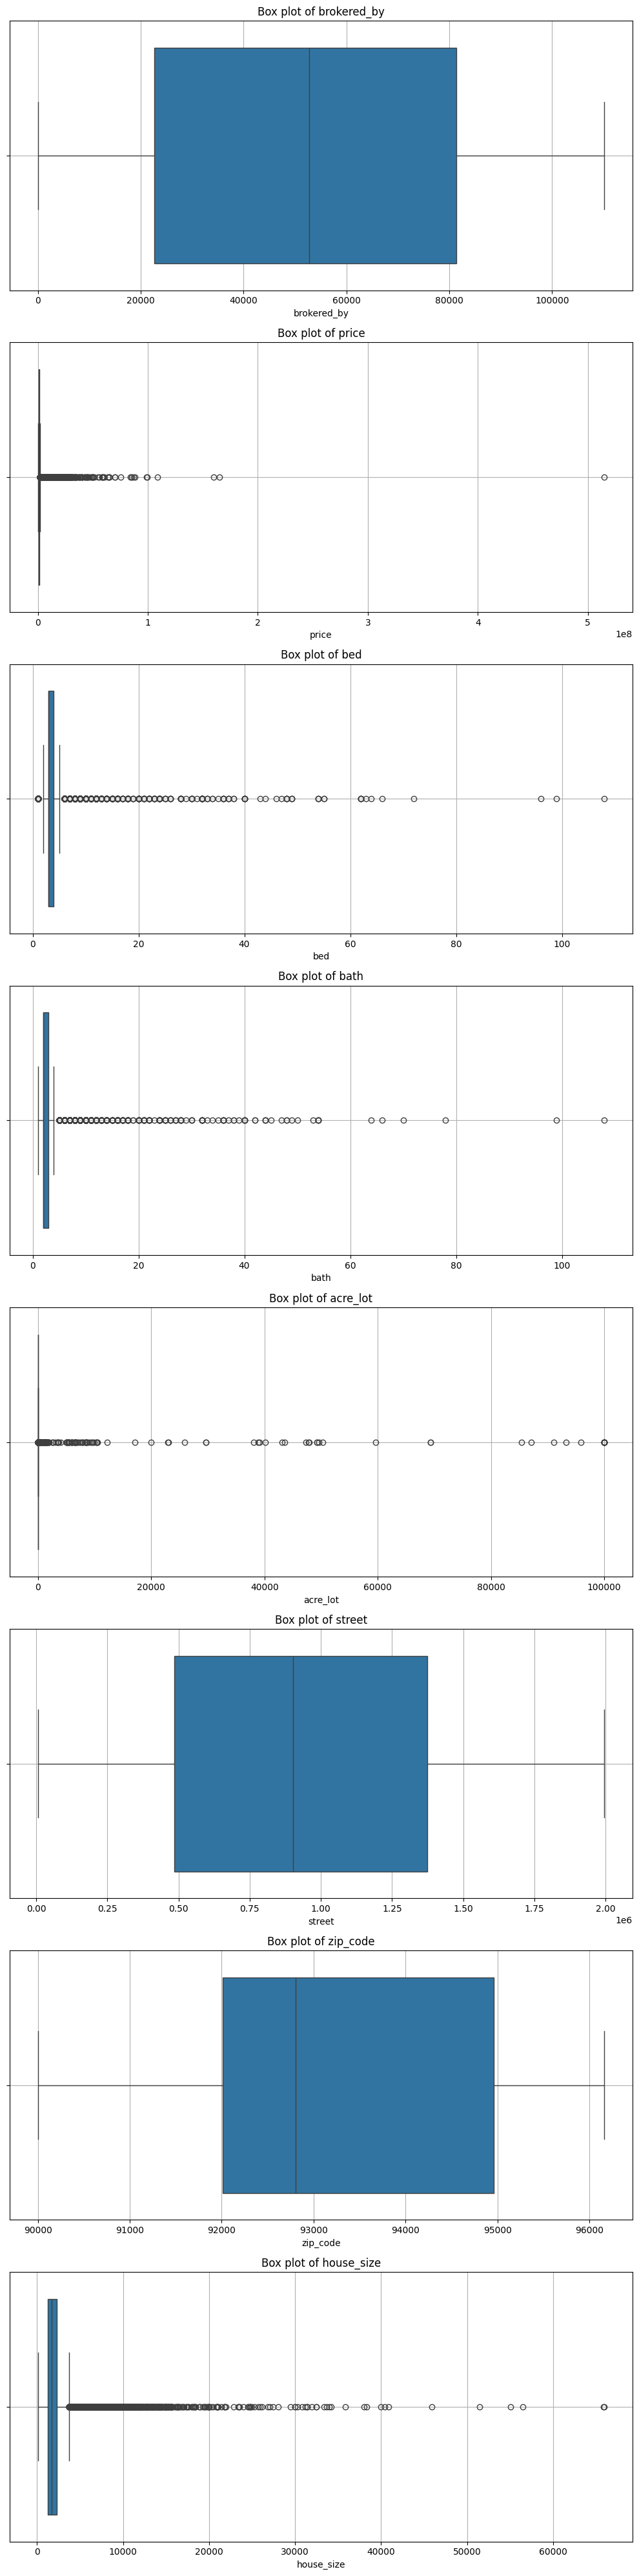

In [18]:
plot_boxplots(California_numeric)

#### Now we are going to clean the data by calling the function that we created above and view the dataset now

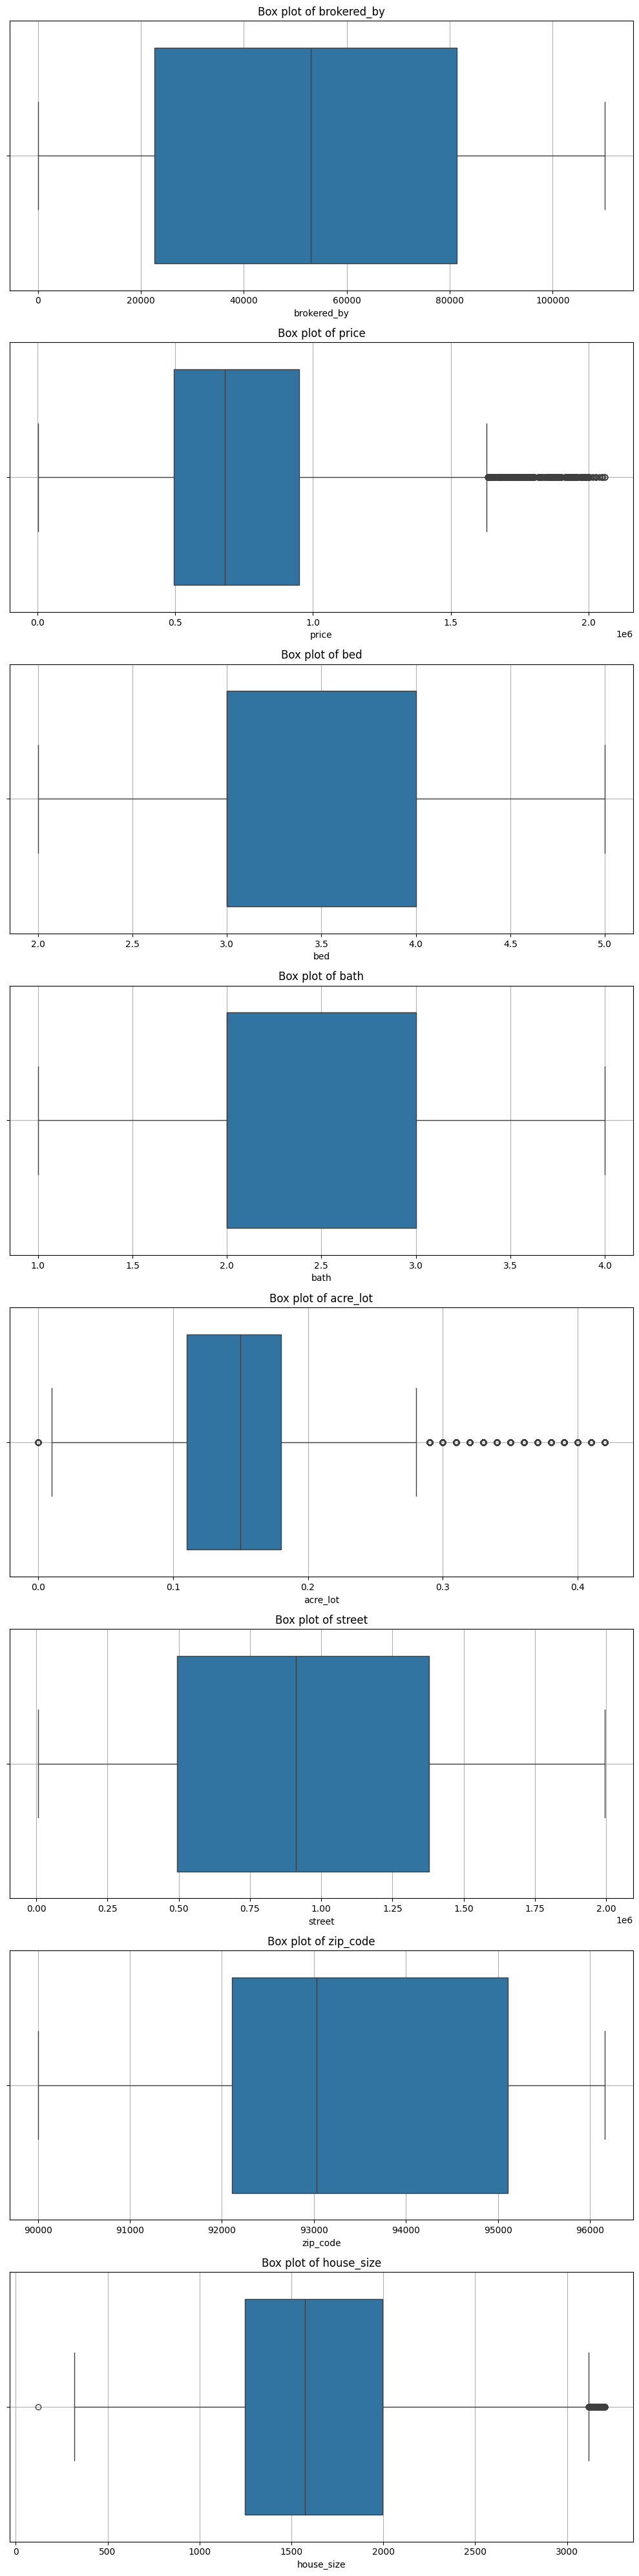

In [19]:
California_numeric_cleaned = remove_outliers(California_numeric)
plot_boxplots(California_numeric_cleaned)

### Analysis Post Outlier Handling

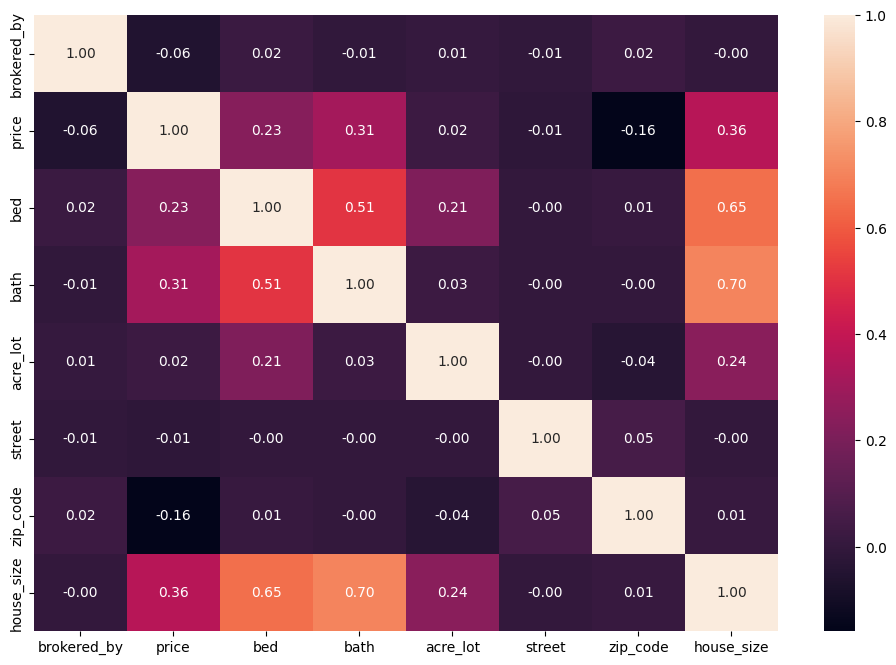

Correlations with the target variable:
 price          1.000000
house_size     0.363328
bath           0.313522
bed            0.231933
acre_lot       0.024939
street        -0.014705
brokered_by   -0.058632
zip_code      -0.158767
Name: price, dtype: float64


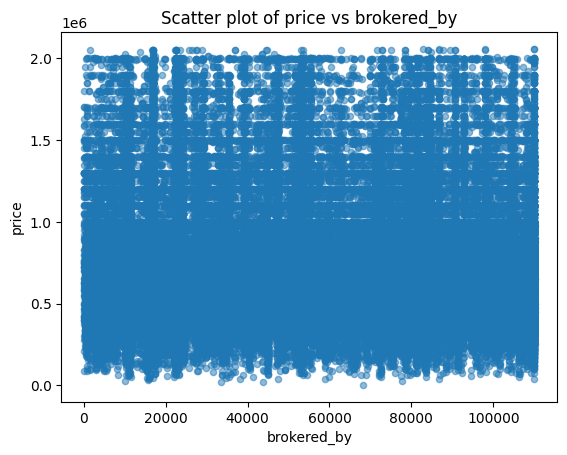

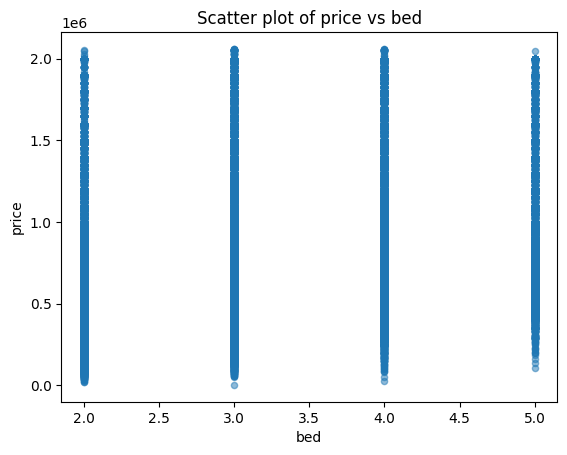

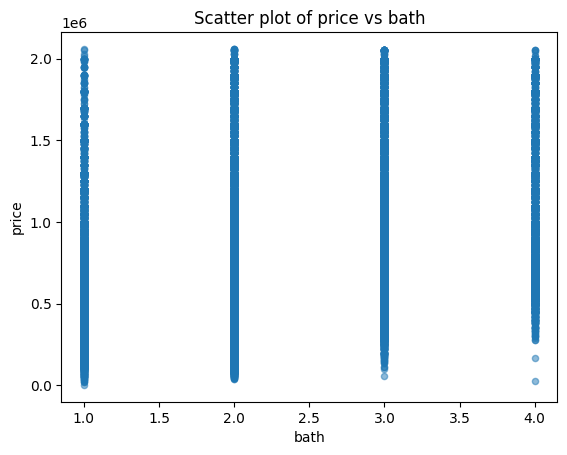

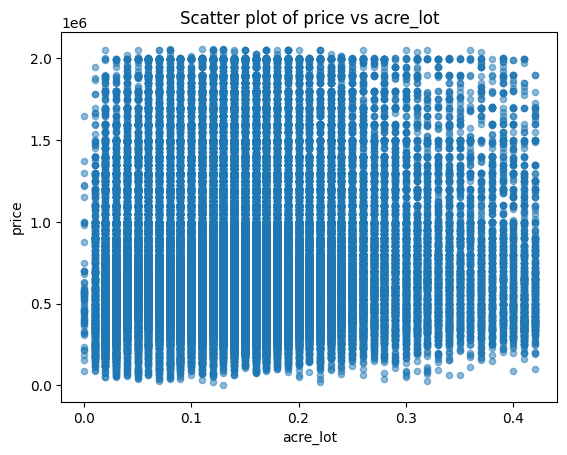

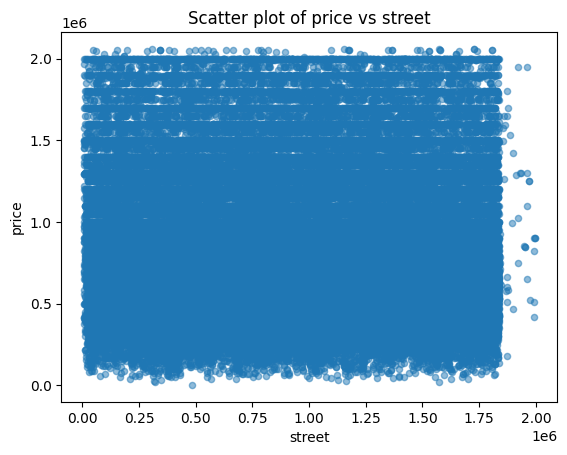

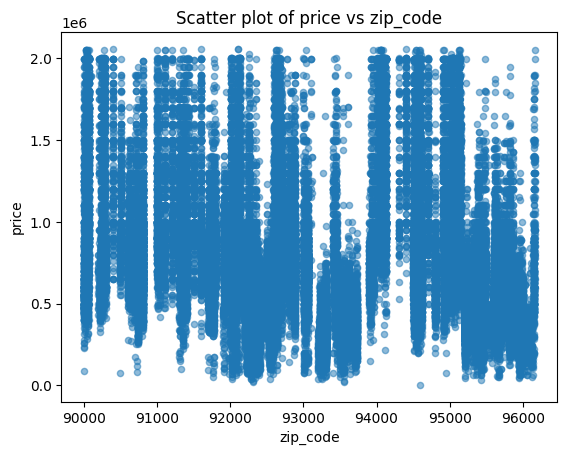

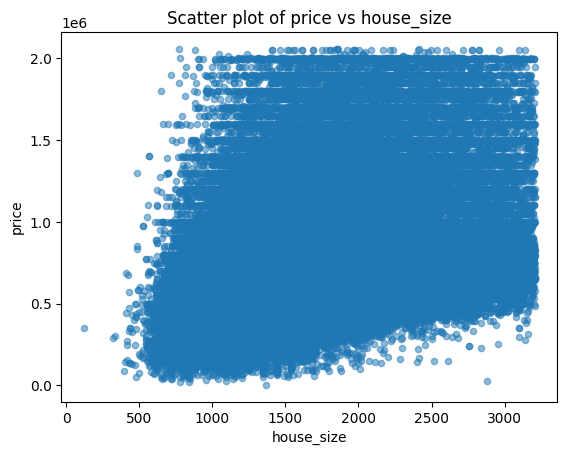

Feature Importances:
        Feature  Importance
5     zip_code    0.633902
6   house_size    0.220720
3     acre_lot    0.053866
4       street    0.041663
0  brokered_by    0.029227
1          bed    0.012083
2         bath    0.008539


In [20]:
correlation_results, feature_importance_results = calculate_correlation(California_numeric_cleaned, 'price')

### Regroup and try the same thing on a grouping of cities in the same area (bay area)

In [21]:

# List of cities in the bay area
cities_to_include = ['Alameda', 'El Cerrito',	'Mountain View',	'San Leandro',
'Albany',	'Emeryville',	'Napa',	'San Mateo',
'American', 'Canyon',	'Fairfax',	'Newark', 'San Pablo'
'Antioch',	'Fairfield',	'Novato',	'San Rafael',
'Atherton',	'Foster City',	'Oakland',	'San Ramon',
'Belmont',	'Fremont',	'Oakley',	'Santa Clara',
'Belvedere',	'Gilroy',	'Orinda',	'Santa Rosa',
'Benicia'	,'Half Moon Bay',	'Pacifica',	'Saratoga',
'Berkeley',	'Hayward',	'Palo Alto',	'Sausalito',
'Brentwood',	'Healdsburg',	'Petaluma',	'Sebastopol',
'Brisbane',	'Hercules',	'Piedmont',	'Sonoma',
'Burlingame',	'Hillsborough',	'Pinole',	'South San Francisco',
'Calistoga',	'Lafayette',	'Pittsburg',	'St. Helena',
'Campbell',	'Larkspur',	'Pleasant Hill',	'Suisun City',
'Clayton',	'Livermore',	'Pleasanton',	'Sunnyvale',
'Cloverdale',	'Los Altos',	'Portola Valley',	'Tiburon'
'Colma',	'Los Altos Hills',	'Redwood City',	'Union City',
'Concord',	'Los Gatos',	'Richmond',	'Vacaville',
'Corte Madera',	'Martinez',	'Rio Vista',	'Vallejo',
'Cotati',	'Menlo Park',	'Rohnert Park',	'Walnut Creek',
'Cupertino',	'Mill Valley','Ross','Windsor',
'Daly City',	'Millbrae',	'San Anselmo'	,'Woodside',
'Danville',	'Milpitas',	'San Bruno',	'Yountville',
'Dixon',	'Monte Sereno',	'San Carlos',	 
'Dublin',	'Moraga',	'San Francisco',	 
'East Palo Alto',	'Morgan Hill',	'San Jose']  # replace with actual city names

# Your original DataFrame is assumed to be named 'original_df'
# Initialize an empty DataFrame to store concatenated rows
Bay_Area = pd.DataFrame()

for city in cities_to_include:
    # Filter the rows where the city column is equal to the current city
    city_df = California[California['city'].isin([city])]
    # Concatenate the filtered rows into the larger DataFrame
    Bay_Area = pd.concat([Bay_Area, city_df], ignore_index=True)


In [24]:
Bay_Area.dropna()
Bay_Area_numeric = Bay_Area.select_dtypes(include=[np.number])   # here we are just going to look at the numeric values to be able visualize the numerical values and their corelation 

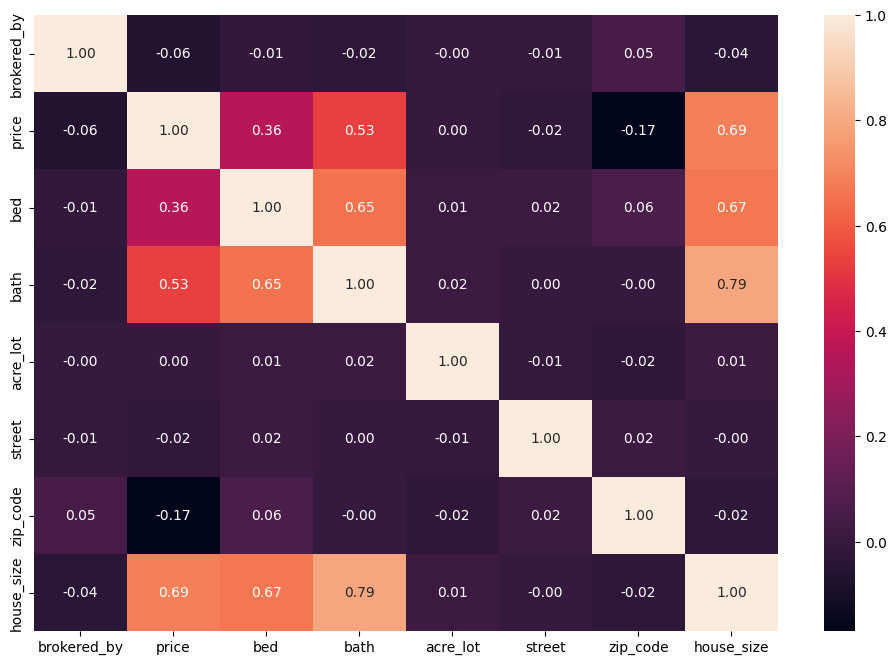

Correlations with the target variable:
 price          1.000000
house_size     0.686321
bath           0.530759
bed            0.357148
acre_lot       0.002706
street        -0.017791
brokered_by   -0.064776
zip_code      -0.169954
Name: price, dtype: float64


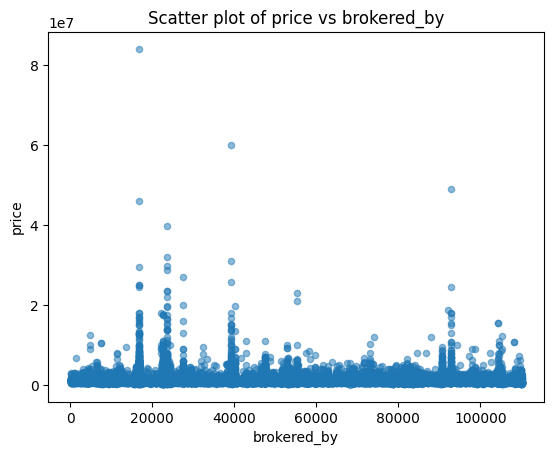

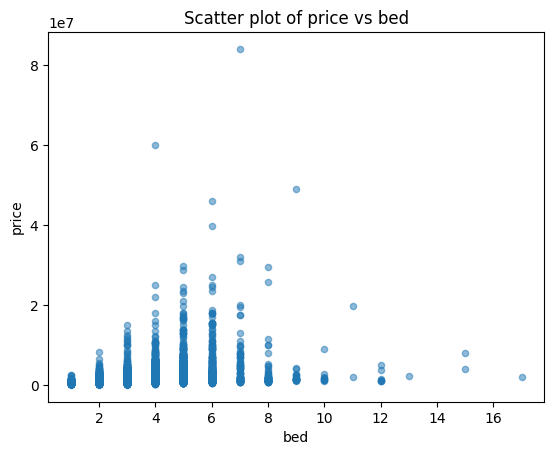

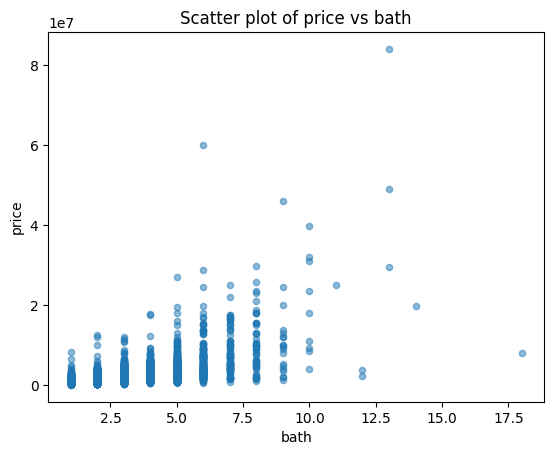

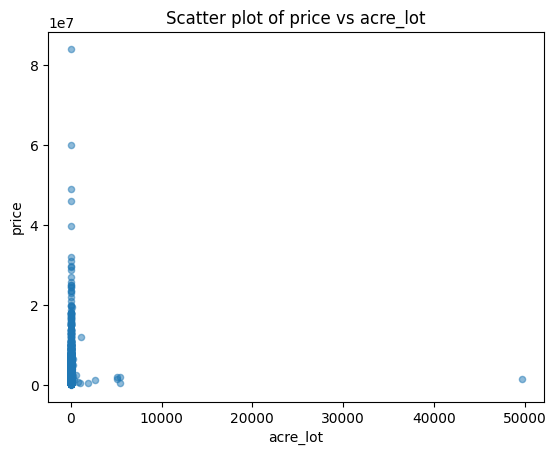

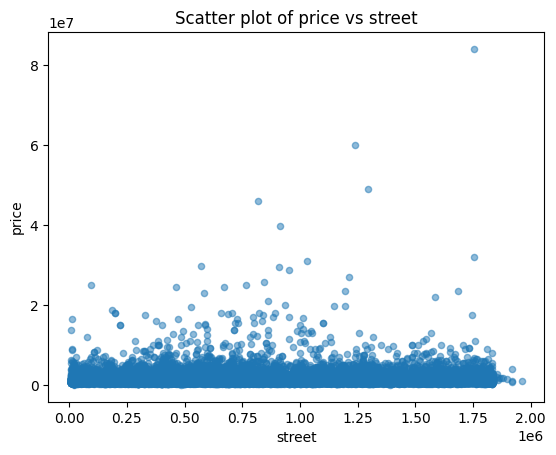

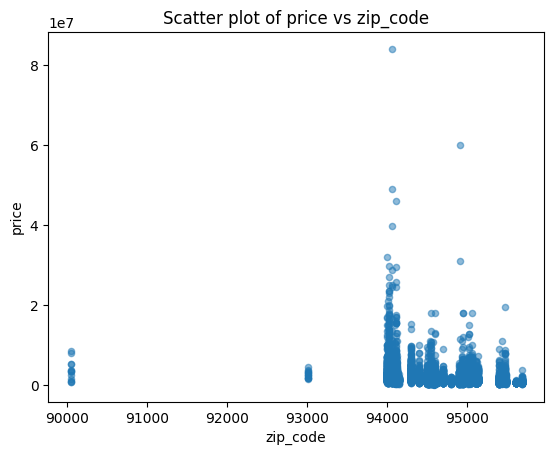

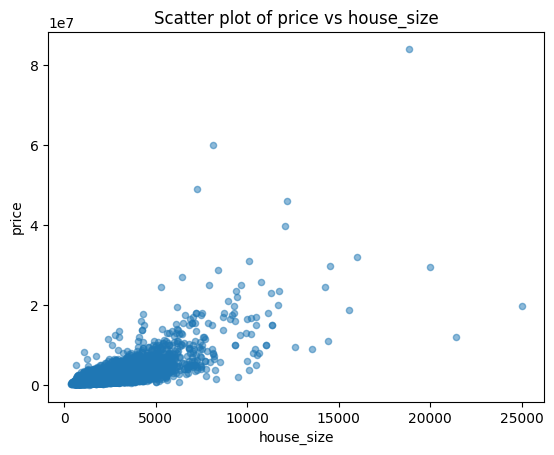

Feature Importances:
        Feature  Importance
6   house_size    0.590737
5     zip_code    0.168574
3     acre_lot    0.079365
2         bath    0.060881
4       street    0.049884
0  brokered_by    0.031886
1          bed    0.018672


In [25]:
correlation_results, feature_importance_results = calculate_correlation(Bay_Area_numeric, 'price')


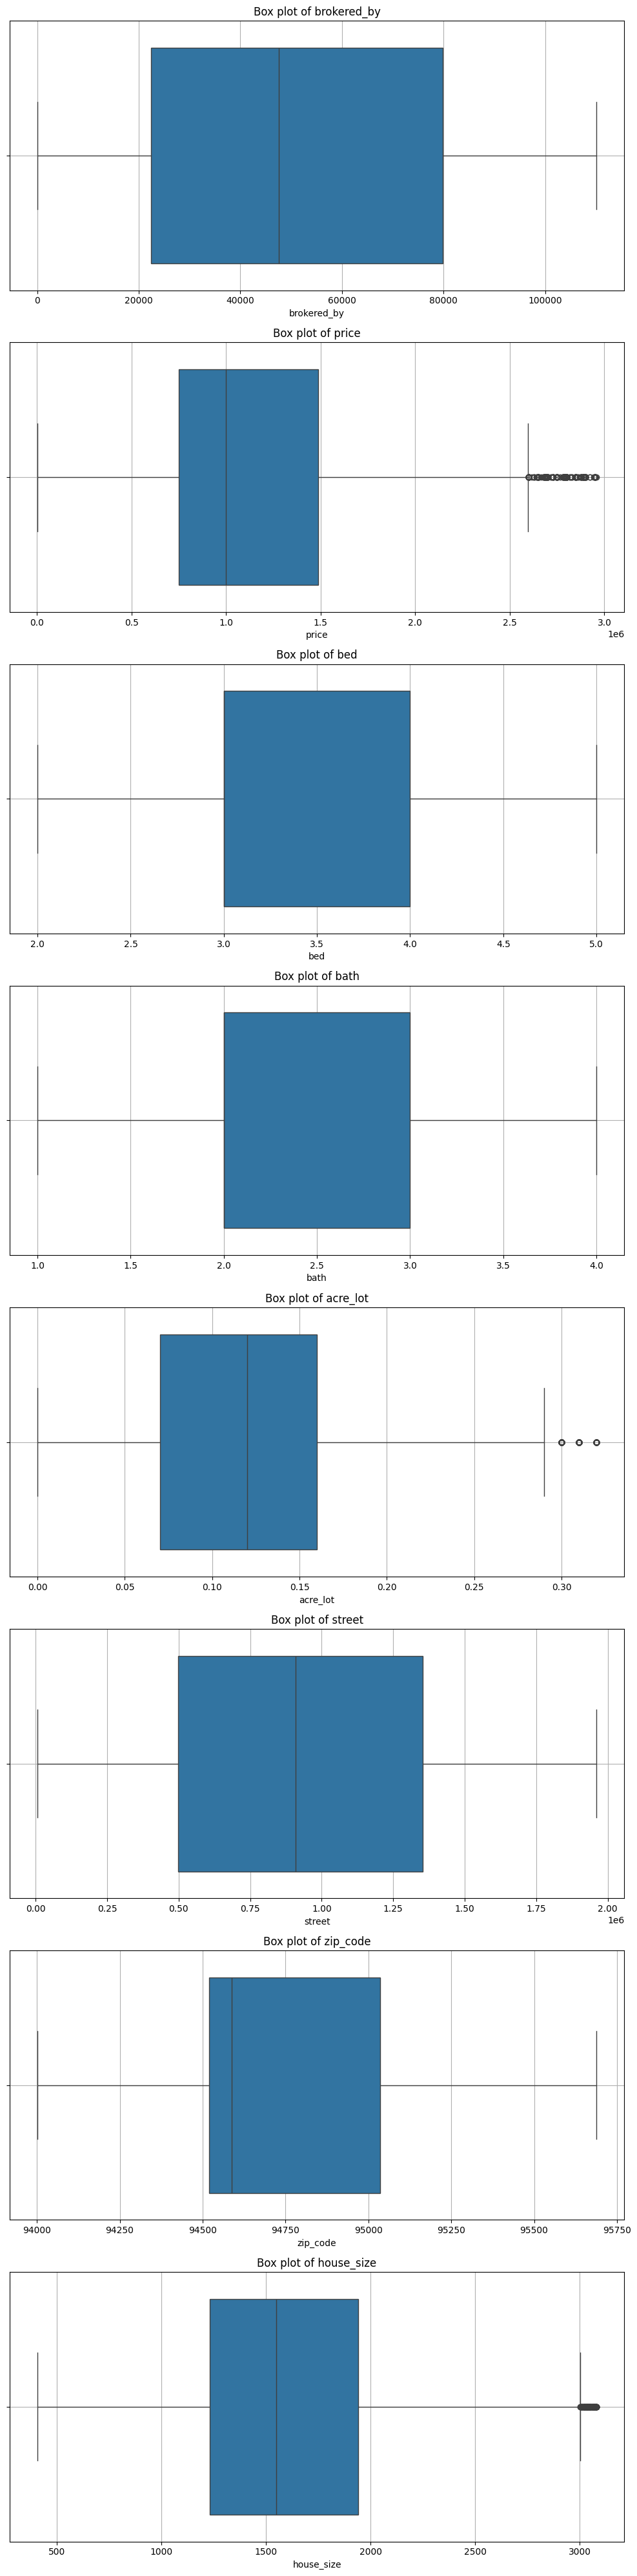

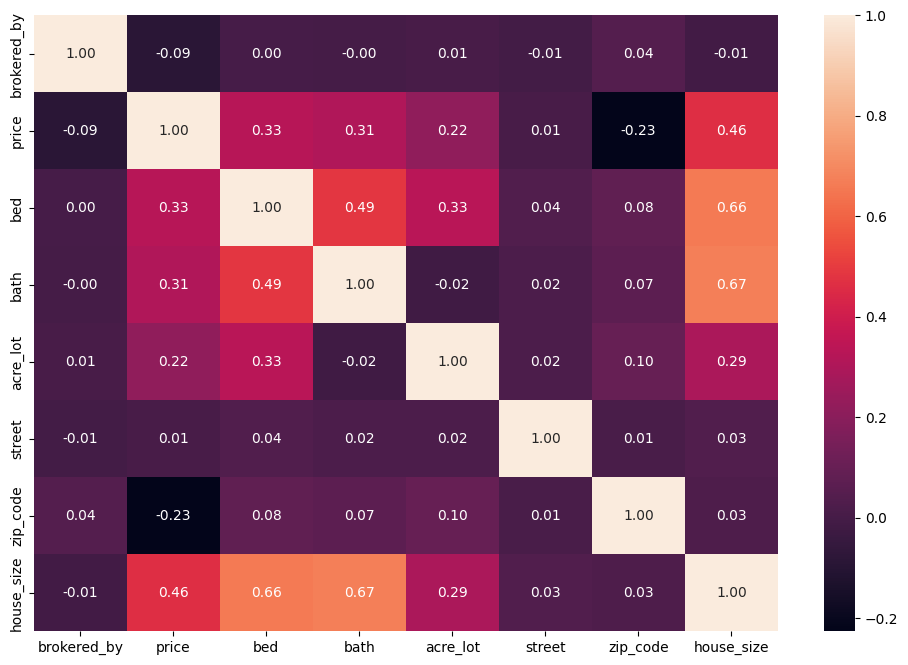

Correlations with the target variable:
 price          1.000000
house_size     0.462400
bed            0.326720
bath           0.309040
acre_lot       0.217640
street         0.005136
brokered_by   -0.087325
zip_code      -0.226178
Name: price, dtype: float64


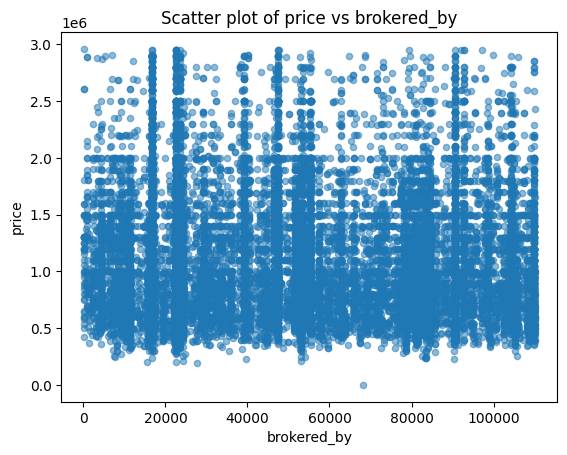

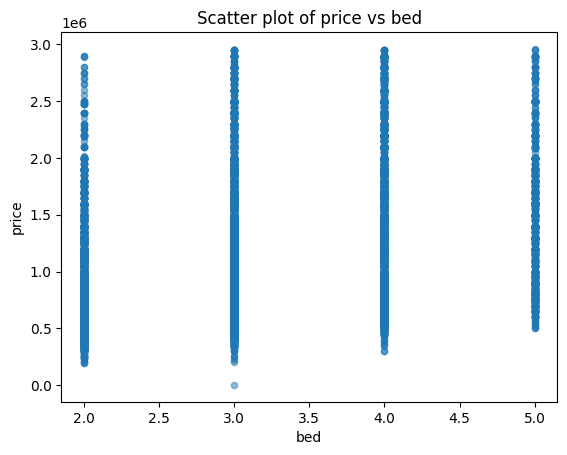

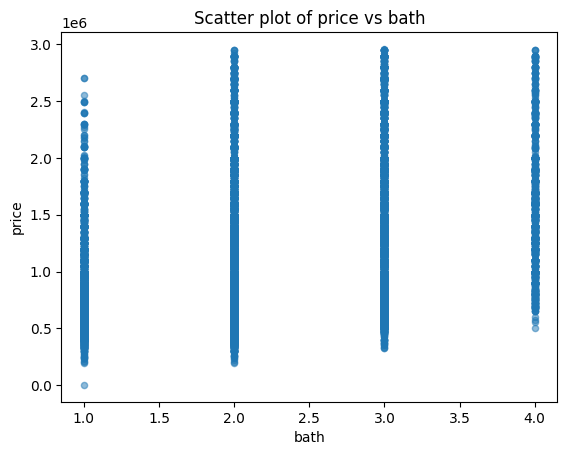

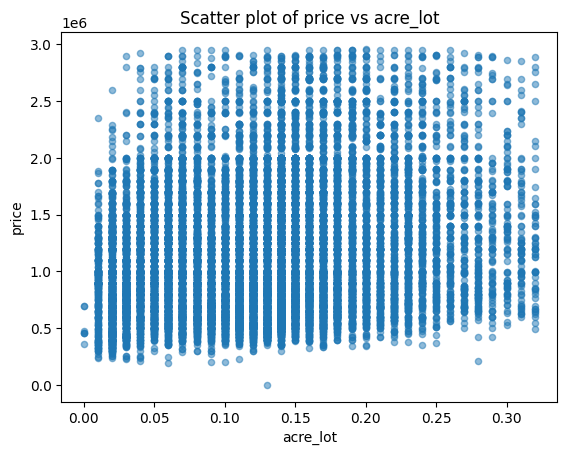

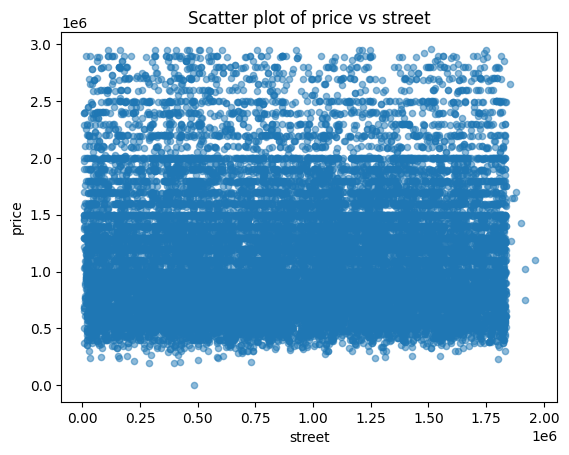

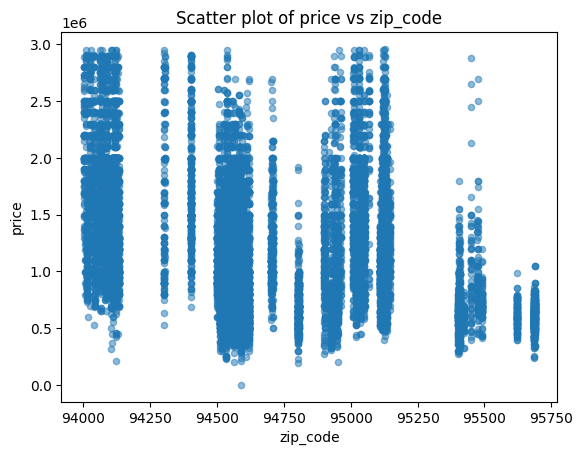

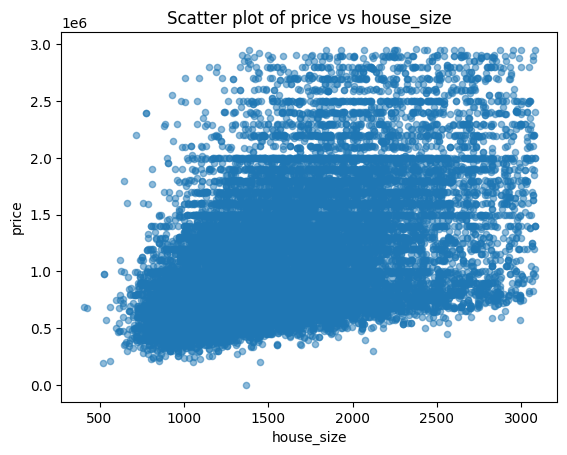

Feature Importances:
        Feature  Importance
5     zip_code    0.489338
6   house_size    0.290454
3     acre_lot    0.099441
4       street    0.059816
0  brokered_by    0.037114
1          bed    0.012765
2         bath    0.011072


In [27]:
Bay_Area_numeric_cleaned = remove_outliers(Bay_Area_numeric)
plot_boxplots(Bay_Area_numeric_cleaned)
correlation_results, feature_importance_results = calculate_correlation(Bay_Area_numeric_cleaned, 'price')
